Yol haritası:


*   Data (UBIRIS V1)
*   Preprocessing(centered, color)


* Segmantasyon (İris) (Canny Edge - Hough Transform ile sınır tespiti)
* Normalization (iris çevresinin kırpılması)
* Feature Extraction (CNN)

* Model Training (CNN)
* Matching (CNN)

Drive üzerindeki datasete erişilmesi. (Bu dataset Yöntem2 dosyasında oluşturulmuştu)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob
import os
import pickle
import random

In [ ]:
import zipfile
import os

In [ ]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(extract_to)
    print(f"{zip_path} içeriği {extract_to} klasörüne çıkarıldı.")

In [ ]:
extract_zip("/content/drive/MyDrive/Bil462_Proje/color_preproces.zip", "image")

/content/drive/MyDrive/Bil462_Proje/color_preproces.zip içeriği image klasörüne çıkarıldı.


Preprocessing ve Segmantasyonun yapılması

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    """
    Görüntüyü kontrastlandır ve gürültüyü azalt.
    """
    # Griye çevir
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE ile kontrastı artır
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Gaussian Blur ile gürültüyü azalt
    denoised = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Morphological Operations ile parlak bölgeleri temizle
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, kernel)

    return cleaned

def apply_canny(image):
    """
    Canny kenar tespit adımı.
    """
    edges = cv2.Canny(image, 50, 150)
    return edges

def detect_circles(edge_image, original_image, filename):
    circles = cv2.HoughCircles(
        edge_image,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=100,
        param2=40,
        minRadius=20,
        maxRadius=50
    )

    result = original_image.copy()

    if circles is not None:
        circles = np.uint16(np.around(circles))

        # Görüntünün merkezini bul
        h, w = original_image.shape[:2]
        image_center = np.array([w // 2, h // 2])

        distances = []
        for x, y, radius in circles[0]:
            distance = np.sqrt((x - image_center[0])**2 + (y - image_center[1])**2)
            distances.append((distance, x, y, radius))

        # En yakın çemberi seç
        distances = sorted(distances, key=lambda t: t[0])
        closest_circle = distances[0]
        x, y, radius = closest_circle[1:]

         # Iris bölgesini kare olarak kırp
        side_length = int(2 * radius)
        x1, y1 = max(x - side_length // 2, 0), max(y - side_length // 2, 0)
        x2, y2 = min(x1 + side_length, w), min(y1 + side_length, h)

        cropped_iris = original_image[y1:y2, x1:x2]

        resized_iris = cv2.resize(cropped_iris, (150, 150))

        save_path = os.path.join(output_dir, f"{filename}")
        cv2.imwrite(save_path, resized_iris)

        print(f"{filename}: Iris başarıyla kırpıldı ve {save_path} adresine kaydedildi.")
    else:
      print(f"{filename} Bulunamadı")



İris çevresi kırpılmış görsellerin kayıt edilmesi, sonraki çalıştırmalar için saklanması

In [ ]:
import os
import cv2

input_dir = "./image"
output_dir = "./crop"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".jpg"):
      filepath = os.path.join(input_dir, filename)
      image = cv2.imread(filepath)
      preprocessed = preprocess_image(image)
      edges = apply_canny(preprocessed)

      detect_circles(edges, image, filename)
print(f"Tüm görüntüler {output_dir} klasörüne kaydedildi.")


162.1190.jpg: Iris başarıyla kırpıldı ve ./crop/162.1190.jpg adresine kaydedildi.
210.1596.jpg: Iris başarıyla kırpıldı ve ./crop/210.1596.jpg adresine kaydedildi.
107.729.jpg: Iris başarıyla kırpıldı ve ./crop/107.729.jpg adresine kaydedildi.
228.1749.jpg: Iris başarıyla kırpıldı ve ./crop/228.1749.jpg adresine kaydedildi.
241.1845.jpg: Iris başarıyla kırpıldı ve ./crop/241.1845.jpg adresine kaydedildi.
210.1605.jpg Bulunamadı
146.1048.jpg: Iris başarıyla kırpıldı ve ./crop/146.1048.jpg adresine kaydedildi.
232.1781.jpg: Iris başarıyla kırpıldı ve ./crop/232.1781.jpg adresine kaydedildi.
208.1582.jpg: Iris başarıyla kırpıldı ve ./crop/208.1582.jpg adresine kaydedildi.
85.570.jpg: Iris başarıyla kırpıldı ve ./crop/85.570.jpg adresine kaydedildi.
56.396.jpg: Iris başarıyla kırpıldı ve ./crop/56.396.jpg adresine kaydedildi.
198.1487.jpg: Iris başarıyla kırpıldı ve ./crop/198.1487.jpg adresine kaydedildi.
152.1099.jpg Bulunamadı
17.128.jpg: Iris başarıyla kırpıldı ve ./crop/17.128.jpg adr

In [ ]:
from google.colab.patches import cv2_imshow

İris bulunamayan resimlerin atılmasından sonra güncel katılımcı sayısının ve fotoğraf sayısının görüntülenmesi

In [ ]:
import os

output_dir = "./crop"

participant_ids = set()
photo_nums = set()

for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        participant_id, photo_num = filename.replace('.jpg', '').split('.')
        participant_ids.add(int(participant_id))
        photo_nums.add(int(photo_num))

num_participants = len(participant_ids)
num_photos = len(photo_nums)

print(f"Klasörde {num_participants} benzersiz participantID bulundu.")
print(f"Klasörde toplam {num_photos} benzersiz fotoğraf numarası bulundu.")


Klasörde 244 benzersiz participantID bulundu.
Klasörde toplam 1483 benzersiz fotoğraf numarası bulundu.


In [ ]:
# Dataset Config
SIZE = 1483
NUM_CLASSES = 244
IMG_HEIGHT = 150
IMG_WIDTH = 150
NUM_CHANNELS = 3
input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

Dosya adlarından label bilgisinin elde edilmesi

In [ ]:
import os
import pandas as pd

def load_dataset(path):

    labels = []
    images = []

    # Dataset klasöründe dolaşıp tüm resimleri oku
    for image in os.listdir(path):
        if image.endswith('.jpg'):
            participant_id = image.split('.')[0]  # participantID'yi al
            img_path = os.path.join(path, image)

            images.append(img_path)
            labels.append(int(participant_id))  # participantID'yi label olarak kullan

    # DataFrame oluştur
    df = pd.DataFrame({'Label': labels, 'ImagePath': images})
    return df

dataset_path = '/content/crop'
df = load_dataset(dataset_path)

print(df.head())

   Label                   ImagePath
0    162  /content/crop/162.1190.jpg
1    210  /content/crop/210.1596.jpg
2    107   /content/crop/107.729.jpg
3    228  /content/crop/228.1749.jpg
4    241  /content/crop/241.1845.jpg


In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)  # OpenCV ile oku

    img = img.astype(np.float32) / 255.0

    return img

Train, test ve validation setlerin oluşturulması. (Her katılımcı için 1 test, 1 veya 2 validation görseli alınmış olup geri kalan train sete aktarılmıştır)

In [ ]:
def split_dataset(preprocessed_images, preprocessed_labels, shuffle=True):
    np.random.seed(1190652)

    # Map participantID to their image indices
    participant_to_indices = {}
    for idx, label in enumerate(preprocessed_labels):
        if label not in participant_to_indices:
            participant_to_indices[label] = []
        participant_to_indices[label].append(idx)

    # Prepare indices for train, validation, and test sets
    train_indices = []
    validation_indices = []
    test_indices = []

    for participant, indices in participant_to_indices.items():
        if shuffle:
            np.random.shuffle(indices)

        # Assign based on the number of images per participant
        if len(indices) > 6:
            # 2 for validation, 2 for testing, rest for training
            validation_indices.extend(indices[:2])  # First 2 for validation
            test_indices.extend(indices[2:3])      # Next 2 for testing
            train_indices.extend(indices[3:])      # Remaining for training
        elif len(indices) >= 2:
            # 1 for validation, 1 for testing, rest for training
            validation_indices.append(indices[0])  # First for validation
            test_indices.append(indices[1])        # Second for testing
            train_indices.extend(indices[2:])      # Remaining for training
        elif len(indices) == 1:
            # If only one image exists, use it for testing
            test_indices.append(indices[0])

    # Create datasets
    x_train = preprocessed_images[train_indices]
    y_train = preprocessed_labels[train_indices]
    x_valid = preprocessed_images[validation_indices]
    y_valid = preprocessed_labels[validation_indices]
    x_test = preprocessed_images[test_indices]
    y_test = preprocessed_labels[test_indices]

    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [ ]:
def prepare_dataset(df):

    preprocessed_images = []
    for img_path in df['ImagePath']:
        image = preprocess_image(img_path)
        preprocessed_images.append(image)

    preprocessed_images = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    preprocessed_labels = df['Label'].values
    return split_dataset(preprocessed_images, preprocessed_labels)


In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = prepare_dataset(df)
print("Triaing set size: ", x_train.shape)
print("Validation set size: ", x_valid.shape)
print("Testing set size: ",x_test.shape)

Triaing set size:  (908, 150, 150, 3)
Validation set size:  (331, 150, 150, 3)
Testing set size:  (244, 150, 150, 3)


In [ ]:
import math
import cv2
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import Sequential
from sklearn.model_selection import cross_val_score
from keras import backend as K
from tensorflow import keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score,  roc_curve, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer, Input, Dense,Dropout, Conv2D, BatchNormalization, Flatten, Input, Conv2D, GaussianNoise,MaxPooling2D, Flatten, Dense, Dropout


Model oluşturulurken
 "Sondos, An End-to-end segmentation-free approach Iris Biometric Authentication, Open Source (GitHub & Kaggle), May 2024." yardım alınmıştır.

In [ ]:
# Training Config:
EPOCHS = 130
BATCH_SIZE = 32
loss = 'sparse_categorical_crossentropy'
# optimizer = 'adam'
activation = "leaky_relu"
initial_learning_rate = 0.0010000000474974513
optimizer = Adam(learning_rate=initial_learning_rate)

mcp_save = ModelCheckpoint('.mdl_wts.keras', save_best_only=True, monitor='val_loss', mode='min')

def create_model():
    """
    Create the model architicure and compile it, call on pre-set values.
    Returns:
        model (keras.Sequential): a model compiled with its layers
    """
    padding = 'same'
    poolpadding = 'valid'

    model = Sequential([
        Input(input_shape),
        ####### Features extraction

        Conv2D(32, (5, 5), padding=padding, activation=activation, name="Conv1"),
        BatchNormalization(axis=-1, name="BN1"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool1"),
        GaussianNoise(0.1, name="GaussianNoise"),
        Dropout(0.1, name="Dropout1"),

        Conv2D(64, (5, 5), padding=padding, activation=activation, name="Conv2"),
        BatchNormalization(axis=-1, name="BN2"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool2"),
        Dropout(0.1, name="Dropout2"),

        Conv2D(128, (5, 5), padding=padding, activation=activation, name="Conv3"),
        BatchNormalization(axis=-1, name="BN3"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool3"),
        Dropout(0.25, name="Dropout3"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv4"),
        BatchNormalization(axis=-1, name="BN4"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool4"),
        Dropout(0.25, name="Dropout4"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv5"),
        BatchNormalization(axis=-1, name="BN5"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool5"),
        Dropout(0.25, name="Dropout5"),

        Conv2D(512, (3, 3), padding=padding, activation=activation, name="Conv6"),
        BatchNormalization(axis=-1, name="BN6"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool6"),
        Dropout(0.45, name="Dropout6"),

        Conv2D(512, (2, 2), padding=padding, activation=activation, name="Conv7"),
        BatchNormalization(axis=-1, name="BN7"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool7"),
        Dropout(0.5, name="Dropout7"),

        #### Flatten and fully connected layers, classifier using relu sofftmax
        Flatten(),
        Dense(128, activation=activation, name = "Dense1"),
        Dense(246, activation='softmax', name="SoftmaxClasses"),
    ],
    name="IRISRecognizer")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model



In [ ]:
model = create_model()
model.summary()

Model: "IRISRecognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN1 (BatchNormalization)             │ (None, 150, 150, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool1 (MaxPooling2D)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GaussianNoise (GaussianNoise)        │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 75, 75, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN2 (BatchNormalization)             │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool2 (MaxPooling2D)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 37, 37, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN3 (BatchNormalization)             │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool3 (MaxPooling2D)                │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout3 (Dropout)                   │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN4 (BatchNormalization)             │ (None, 18, 18, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool4 (MaxPooling2D)                │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout4 (Dropout)                   │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN5 (BatchNormalization)             │ (None, 9, 9, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool5 (MaxPooling2D)                │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout5 (Dropout)                   │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,477,558 (13.27 MB)

 Trainable params: 3,474,038 (13.25 MB)

 Non-trainable params: 3,520 (13.75 KB)

Data augmentation ile train sayısını arttırma, modeli güçlendirme

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    rotation_range=15,         # Random rotation
    width_shift_range=0.1,     # Random horizontal shift
    height_shift_range=0.1,    # Random vertical shift
    shear_range=0.1,           # Shearing transformations
    zoom_range=0.1,            # Zoom transformations
    horizontal_flip=True,      # Horizontal flip
    fill_mode='nearest'        # Fill empty pixels
)

train_generator = data_augmentation.flow(
    x_train, y_train,
    batch_size=BATCH_SIZE
)


In [ ]:
history = model.fit(train_generator, validation_data=(np.array(x_valid), y_valid), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[mcp_save])

Epoch 1/130


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 756ms/step - accuracy: 0.0062 - loss: 6.3336 - val_accuracy: 0.0060 - val_loss: 5.5516
Epoch 2/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.0140 - loss: 5.4895 - val_accuracy: 0.0060 - val_loss: 6.0693
Epoch 3/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.0358 - loss: 5.2014 - val_accuracy: 0.0060 - val_loss: 6.5569
Epoch 4/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.0520 - loss: 5.0032 - val_accuracy: 0.0060 - val_loss: 7.5045
Epoch 5/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.0503 - loss: 4.7388 - val_accuracy: 0.0060 - val_loss: 9.4666
Epoch 6/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.0561 - loss: 4.6237 - val_accuracy: 0.0091 - val_loss: 10.5237
Epoch 7/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.0449 - loss: 4.3799 - val_accuracy: 0.0091 - val_loss: 10.5239
Epoch 8/130
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.0912 - loss: 4.2002 - val_accuracy: 0.

Performans Analizleri

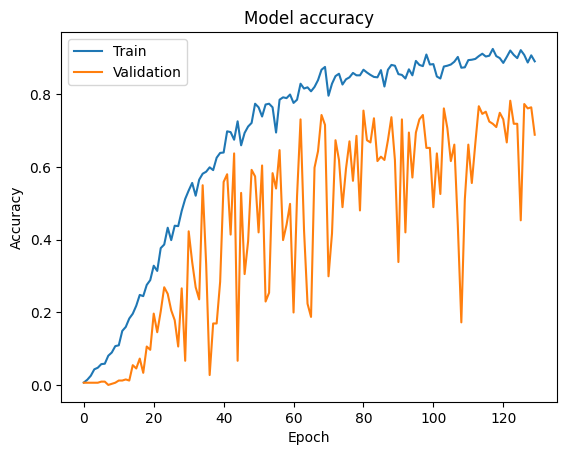

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

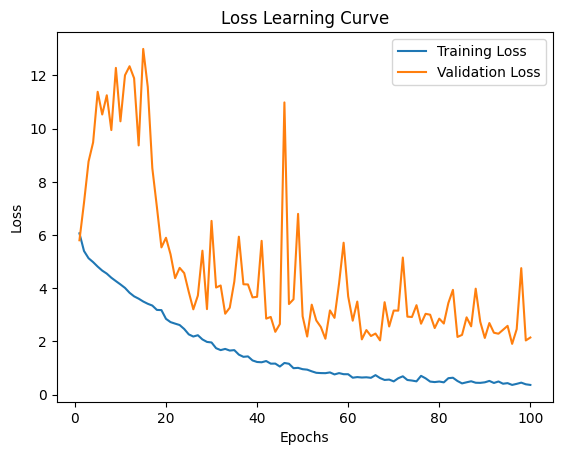

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Modeli kaydetme, sonraki kullanımlarda yükleme

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/my_model (1).keras')

# Modeli yeniden derleme
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Değerlendirme
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7021 - loss: 2.8191
Test accuracy: 70.08%


In [ ]:
probabilites = model.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test  # Gerçek etiketler

correct = np.sum(true_classes == predicted_classes)
incorrect = np.sum(true_classes != predicted_classes)

print(f"Doğru sınıflandırılan iris sayısı: {correct}")
print(f"Yanlış sınıflandırılan iris sayısı: {incorrect}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Doğru sınıflandırılan iris sayısı: 171
Yanlış sınıflandırılan iris sayısı: 73


In [ ]:
correct_predictions = predicted_classes == true_classes
false_predictions = predicted_classes != true_classes

# False Positives ve False Negatives hesaplama
false_positives = np.sum((predicted_classes != true_classes) & (true_classes != predicted_classes))
false_negatives = np.sum((predicted_classes != true_classes) & (true_classes == predicted_classes))
true_positives = np.sum((predicted_classes == true_classes) & (true_classes == predicted_classes))
true_negatives = np.sum((predicted_classes != true_classes) & (true_classes != predicted_classes))

# FAR ve FRR hesaplama
FAR = false_positives / (false_positives + true_negatives)
FRR = false_negatives / (false_negatives + true_positives)

print(f"False Accept Rate (FAR): {FAR}")
print(f"False Reject Rate (FRR): {FRR}")

False Accept Rate (FAR): 0.5
False Reject Rate (FRR): 0.0


In [ ]:
print(false_positives)
print(false_negatives)
print(true_positives)
print(true_negatives)

73
0
171
73


In [ ]:
# Calculate Accuracy
accuracy = np.mean(predicted_classes == true_classes)

# Calculate Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

# Calculate Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + FN) > 0 else 0

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.7008196721311475
Precision: 0.7008196721311475
Recall: 1.0


In [ ]:
def f1_metric(y_true, y_pred):


    return 2 * (precision * recall) / (precision + recall + 1e-8)

# Testte f1 metrik hesapla
f1 = f1_metric(y_test, predictions)

print(f'F1: {f1.item()}')

F1: 0.8240963806968791


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 244

for i in range(num_classes):
    y_true_binary = np.where(y_test == i, 1, 0)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, probabilites[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


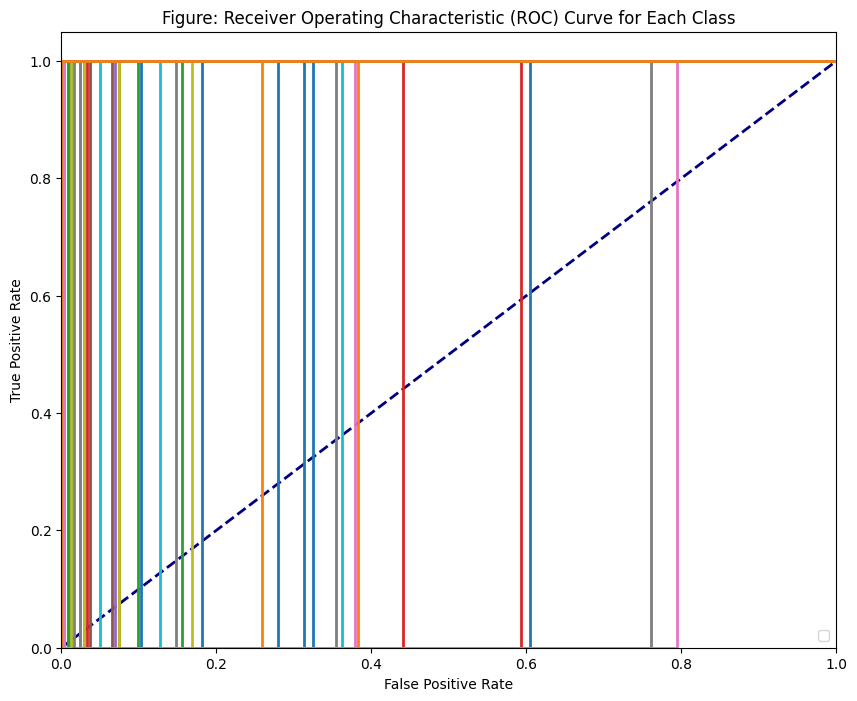

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  ## this is the state of a random classifier

for i in range(num_classes):
    if not math.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], lw=2)#, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure: Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
eer_thresholds = []

for i in range(num_classes):
    try:
        fpr_values = fpr[i]
        tpr_values = tpr[i]
        interp_fn = interp1d(fpr_values, tpr_values)
        def eer_fn(x):
            return 1.0 - x - interp_fn(x)

        eer_threshold = brentq(eer_fn, 0.0, 1.0)
        eer_thresholds.append(eer_threshold)
    except ValueError:
        continue

avg_eer_threshold = np.mean(eer_thresholds)
print(f"Equal Error Rate (EER) Threshold: {avg_eer_threshold:.4f}")

Equal Error Rate (EER) Threshold: 0.0313


In [ ]:
def evaluate_model_visualize(dataset, y_true, model, class_names):

    num_rows = 4
    num_cols = 6
    data_batch = dataset[0:num_rows * num_cols]
    predictions = model.predict(data_batch)
    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx][:, :, ::-1])

        pred_idx = np.argmax(predictions[idx])
        true_idx = y_true[idx]

        title = f"{class_names[true_idx]} : {class_names[pred_idx]}"
        title_obj = plt.title(title, fontdict={"fontsize": 13})

        if pred_idx == true_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")
    acc = num_matches / (num_rows * num_cols)
    print("Prediction accuracy: {:.2%}".format(acc))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


IndexError: index 244 is out of bounds for axis 0 with size 244

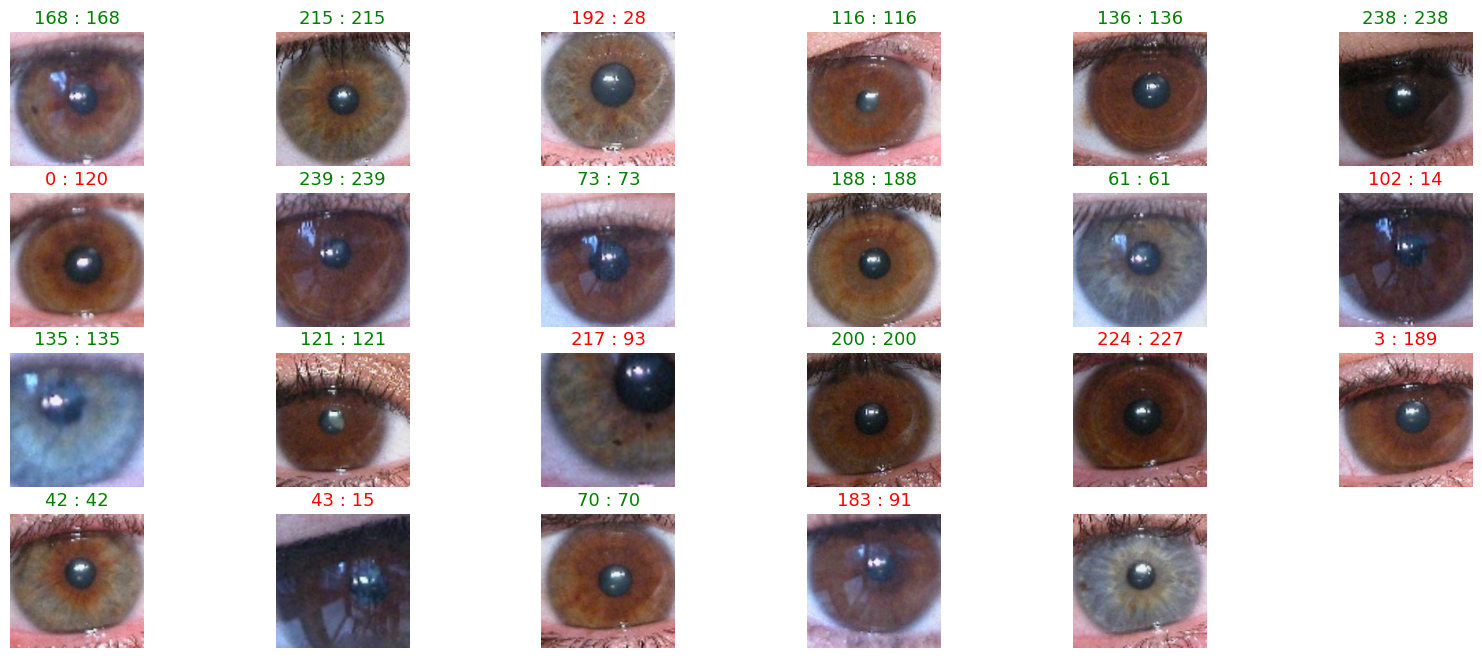

In [ ]:
evaluate_model_visualize(x_test,y_test, model,df['Label'].unique())